## Generate subset for experiments
- datasets: ultrafeedback, hh

In [2]:
from datasets import load_dataset
from collections import OrderedDict 
import pandas as pd
import numpy as np
import random
import os

random.seed(3)
np.random.seed(3)

def extract_random_susbet(dataset_name, selected_indices, dataset_with_docta_score):

    data_size = len(selected_indices)

    random_indices = np.random.choice(len(dataset_with_docta_score), size=data_size, replace=False)

    random_subset = dataset_with_docta_score.select(random_indices)
    count = 0
    for sample in random_subset:
        if abs(sample['chosen_docta_score'] - sample['rejected_docta_score']) < 0.1:
            count += 1
            
    print(f"The similar pair proportion in the random subset: {round(count / len(random_subset) * 100, 2)} %")
    random_subset.to_json(f"{dataset_name}_random_subset.json")
    
    print(f"stored data in {dataset_name}_random_subset.json!")

def print_pair_proportion_info(dataset_name, docta_dataset):

    equal_pair_count = 0
    noisy_pair_count = 0
    
    selected_indices = []
    noisy_indices = []
    for idx, sample in enumerate(docta_dataset):
        
        if abs(sample['chosen_docta_score'] - sample['rejected_docta_score']) < 0.01 or 'similar' == sample['docta_category']:
            equal_pair_count +=1
        else:
            if sample['chosen_docta_score'] < sample['rejected_docta_score']:
                noisy_pair_count +=1
                noisy_indices.append(idx)
            
            selected_indices.append(idx)

    # count / len(docta_dataset['docta_category'])
    # len(docta_dataset['docta_category']) - count
    print(f"## similar pair proportion in the original {dataset_name} dataset: {round(equal_pair_count/len(docta_dataset) * 100, 2)} %")
    print(f"## noisy pair proportion in the original {dataset_name} dataset: {round(noisy_pair_count/len(docta_dataset) * 100, 2)} %")
    print(f"## noisy pair proportion in the selected (non-similar pair) subset: {round(noisy_pair_count/len(selected_indices) * 100, 2)} %")
    print(f"noisy sample counts: {len(noisy_indices)}; selected_indices: {len(selected_indices)} out of original size {len(docta_dataset)}!")
    
    return noisy_indices, selected_indices

def concatenate_docta_score_to_orig_dataset(dataset_name, orig_train_dataset):

    # docta_scores_all = docta_dataset.map(
    #     remove_columns=[name for name in docta_dataset.column_names if name not in ['chosen_docta_score', 'rejected_docta_score']],
    #     desc="Tokenizing and reformatting instruction data",
    # )
    temp = orig_train_dataset.add_column('chosen_docta_score', docta_dataset['chosen_docta_score'])
    dataset_with_docta_score = temp.add_column('rejected_docta_score', docta_dataset['rejected_docta_score'])

    
    return dataset_with_docta_score

def extract_selected_clean_subset(selected_indices, noisy_indices, dataset_with_docta_score):
    
    selected_subset_with_docta_score = dataset_with_docta_score.select(selected_indices)
    selected_subset_with_docta_score.to_json("hh_selected_subset.json")

    def swap_chosen_rejected(example, idx):
        if idx in noisy_indices:
            # 交换 chosen 和 rejected
            example['chosen'], example['rejected'] = example['rejected'], example['chosen']
            
            # 交换 chosen_docta_score 和 rejected_docta_score
            example['chosen_docta_score'], example['rejected_docta_score'] = example['rejected_docta_score'], example['chosen_docta_score']
        
        return example

    #### docta clean subset before selected_indices
    clean_dataset_with_docta_score = dataset_with_docta_score.map(
        swap_chosen_rejected,
        with_indices=True  
    )

    selected_clean_subset_with_docta_score = clean_dataset_with_docta_score.select(selected_indices)
    
    return selected_clean_subset_with_docta_score

def extract_random_subset(data_size, dataset_with_docta_score):

    random_indices = np.random.choice(len(dataset_with_docta_score), size=data_size, replace=False)
    random_subset = dataset_with_docta_score.select(random_indices)
    count = 0
    for sample in random_subset:
        if abs(sample['chosen_docta_score'] - sample['rejected_docta_score']) < 0.1:
            count += 1
            
    print(f"The similar pair proportion in the random subset: {round(count / len(random_subset) * 100, 2)} %")
    
    return random_subset 


##############################################################################
##############################################################################

dataset_name = 'ultrafeedback' #hh ultrafeedback

print(f"#### dataset_name: {dataset_name} #### \n")
if dataset_name == 'ultrafeedback':
    orig_data_name = "argilla/ultrafeedback-binarized-preferences-cleaned" 
    docta_data_dir = "0093775ultrafeedback_docta.json" 
    
elif dataset_name == 'hh':
    orig_data_name = 'Anthropic/hh-rlhf' 
    docta_data_dir = '2628431hh_all_docta.json'
else:
    raise NotImplementedError

### load data
orig_train_dataset = load_dataset(orig_data_name)['train']
docta_dataset= load_dataset("json", data_files=docta_data_dir)['train']

### statistical information
noisy_indices, selected_indices = print_pair_proportion_info(dataset_name, docta_dataset)

## add docta score to the original dataset
dataset_with_docta_score = concatenate_docta_score_to_orig_dataset(dataset_name, orig_train_dataset)

##generate the selected clean subset/random subset
selected_clean_subset = extract_selected_clean_subset(selected_indices, noisy_indices, dataset_with_docta_score)
random_subset = extract_random_subset(len(selected_indices), dataset_with_docta_score)




# data_path = f'./dataset/'
# if not os.path.exists(data_path):
#     os.makedirs(data_path)


# dataset_with_docta_score.to_json(f"{dataset_name}_with_docta_score.json")
# selected_clean_subset.to_json(data_path + f"{dataset_name}_selected_clean_subset.json")
# random_subset.to_json(data_path + f"{dataset_name}_random_subset.json")

# print(f"stored data in {data_path + dataset_name}_random_subset.json!")
# print(f"stored data in {data_path + dataset_name}_selected_clean_subset.json!")


# ### show several examples
# docta_df = pd.DataFrame(docta_dataset)
# docta_df.head()

#### dataset_name: ultrafeedback #### 

## similar pair proportion in the original ultrafeedback dataset: 75.82 %
## noisy pair proportion in the original ultrafeedback dataset: 6.15 %
## noisy pair proportion in the selected (non-similar pair) subset: 25.42 %
noisy sample counts: 3744; selected_indices: 14730 out of original size 60917!


Creating json from Arrow format: 100%|██████████| 15/15 [00:00<00:00, 18.98ba/s]


The similar pair proportion in the random subset: 75.75 %


In [18]:
dataset = load_dataset('argilla/ultrafeedback-binarized-preferences-cleaned')['train']


In [24]:
min(dataset['rejected-rating'])

1.0

## Generate a subset with identical pair to illustrate its positive impact.

In [2]:
# dataset_with_docta_score = dataset_with_docta_score.select(range(10))

chosen_docta_scores = dataset_with_docta_score['chosen_docta_score']
rejected_docta_scores = dataset_with_docta_score['rejected_docta_score']


selected_list = []
selected_chosen_scores = []
for idx, sample in enumerate(dataset_with_docta_score):
    # if sample['chosen_docta_score'] ==  sample['rejected_docta_score']:
    if abs(sample['chosen_docta_score'] - sample['rejected_docta_score']) < 0.10:
        selected_chosen_scores
        selected_list.append(idx)

len(selected_list)

46187

In [3]:
from datasets import load_dataset
from collections import OrderedDict 
import pandas as pd
import numpy as np
import random
import os

random.seed(3)
np.random.seed(3)

data_size = 10000

identical_subset = dataset_with_docta_score.select(selected_list)
random_indices = np.random.choice(len(dataset_with_docta_score), size=data_size, replace=False)
random_identical_subset = dataset_with_docta_score.select(random_indices)



# 将列表转换为 numpy 数组（如果它不是 numpy 数组的话）
identical_scores = np.array(identical_subset['chosen_docta_score'])
sorted_idx_desc = np.argsort(identical_scores)[::-1]

# 获取前10000个样本的索引
top_idx = sorted_idx_desc[:data_size]
bottom_idx = sorted_idx_desc[-data_size:]

top_scores = identical_scores[top_idx]
bottom_scores = identical_scores[bottom_idx]

print("random 10000 sample indices:", random_identical_subset['chosen_docta_score'])
print("Top 10000 sample indices:", top_scores)
print("Bottom 10000 sample indices:", bottom_scores)



top_scores_subset = identical_subset.select(top_idx)
bottom_scores_subset = identical_subset.select(bottom_idx)

# random_identical_subset.to_json()
# top_scores_subset.to_json()
# bottom_scores_subset.to_json()


random 10000 sample indices: [0.8160612074, 0.6357189988, 0.7235364325, 0.7286825686, 0.9085510858, 0.9085510858, 0.3557847402, 0.1871206415, 0.5407189988, 0.7256532574, 0.9029635698, 0.7207984302, 0.905, 0.322167913, 0.4047890858, 0.0865368925, 0.6828978284, 0.3025882405, 0.6357189988, 0.5356532574, 0.0923072554, 0.7305422542, 0.9463753132, 0.9964489142, 0.8047188862, 0.6287992477, 0.6708401716, 0.313393208, 0.7152109142, 0.765293758, 0.3075274124, 0.3137907956, 0.9489489142, 0.7673769303, 0.5035510858, 0.4404423432, 0.537167913, 0.9397169111, 0.8610510858, 0.8574528922, 0.854706242, 0.4492700846, 0.5064488661, 0.656395817, 0.4046075883, 0.9525, 0.5854252408, 0.908762, 0.053097826, 0.7174520549, 0.359335826, 0.1847301973, 0.4896038471, 0.6290571412, 0.7711168272, 0.912538329, 0.4442043432, 0.3633272258, 0.3610606391, 0.7183357135, 0.5323130858, 0.2623298888, 0.9014489142, 0.1292131077, 0.5020364302, 0.7718083896, 0.5897336544, 0.2734871062, 0.5430423274, 0.8155142029, 0.9047890858, 0.

In [6]:
from datasets import load_dataset,DatasetDict


def add_scores(example):
    example['chosen_docta_score'] = 1  # 例如，默认值为0.5
    example['rejected_docta_score'] = 0  # 例如，默认值为0.2
    return example

###full dataset
label_dataset_path = "ultrafeedback_with_docta_score.json"
org_test_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['test_prefs']
org_test_dataset = org_test_dataset.map(add_scores) # 使用 map 方法为 test_prefs 添加新列

######################################################
data_name="ultrafeedback-random-identical-subset"

if data_name == "ultrafeedback-bottom-identical-subset":
    final_dataset = bottom_scores_subset
    
elif data_name == "ultrafeedback-top-identical-subset":
    final_dataset = top_scores_subset
    
elif data_name == "ultrafeedback-random-identical-subset":
    final_dataset = random_identical_subset
    
else:
    raise NotImplementedError

new_dataset = DatasetDict({
    'train_prefs': final_dataset,
    'test_prefs': org_test_dataset,
})


# new_dataset.save_to_disk(f"./datasets/{data_name}")


In [4]:
identical_subset[0]

{'source': 'evol_instruct',
 'prompt': 'Identify the interrelated economic, political, and social factors that contributed to the stock market crash of 1929, including but not limited to the impact of World War I on the global economy, the role of government policies such as the Smoot-Hawley Tariff Act, the effects of speculative investment practices and margin trading, and the socioeconomic disparities of the time period. Additionally, provide a comparative analysis of the causes and effects of the 1929 stock market crash with other notable financial crises in history, such as the Great Depression of the 1930s and the 2008 global financial crisis. Use primary and secondary sources to support your analysis and provide data visualizations, such as graphs and charts, to illustrate your findings.',
 'chosen': [{'content': 'Identify the interrelated economic, political, and social factors that contributed to the stock market crash of 1929, including but not limited to the impact of World W

In [5]:
len(identical_subset[0]['chosen'][0]['content'])

764

In [33]:

sample_lens = []
for sample in identical_subset:
    
    chosen_response_len = len(sample['chosen'][1]['content'])
    rejected_response_len =  len(sample['rejected'][1]['content'])
    prompt_len = len(sample['rejected'][0]['content'])
    
    sample_lens.append(prompt_len + chosen_response_len + rejected_response_len)
    

sample_lens_array = np.array(sample_lens)
sorted_idx = np.argsort(sample_lens_array)



## Print identical examples

In [48]:
top_sorted_idx = sorted_idx[:100]
print_sample = identical_subset.select(top_sorted_idx)

sample = print_sample[44]

print(sample['prompt'])
print(sample['chosen'][-1]['content'] + " & " + sample['rejected'][-1]['content'])
print(str(sample['chosen-rating']) + " & " + str(sample['rejected-rating']))
print(str(round(sample['chosen_docta_score'],3)) + " & " + str(round(sample['rejected_docta_score'],3)))

Join the two sentences together using the correct punctuation.
He was absent. He didn't call.
He was absent; he didn't call. & He was absent and he didn't call.
5.0 & 4.0
0.313 & 0.313


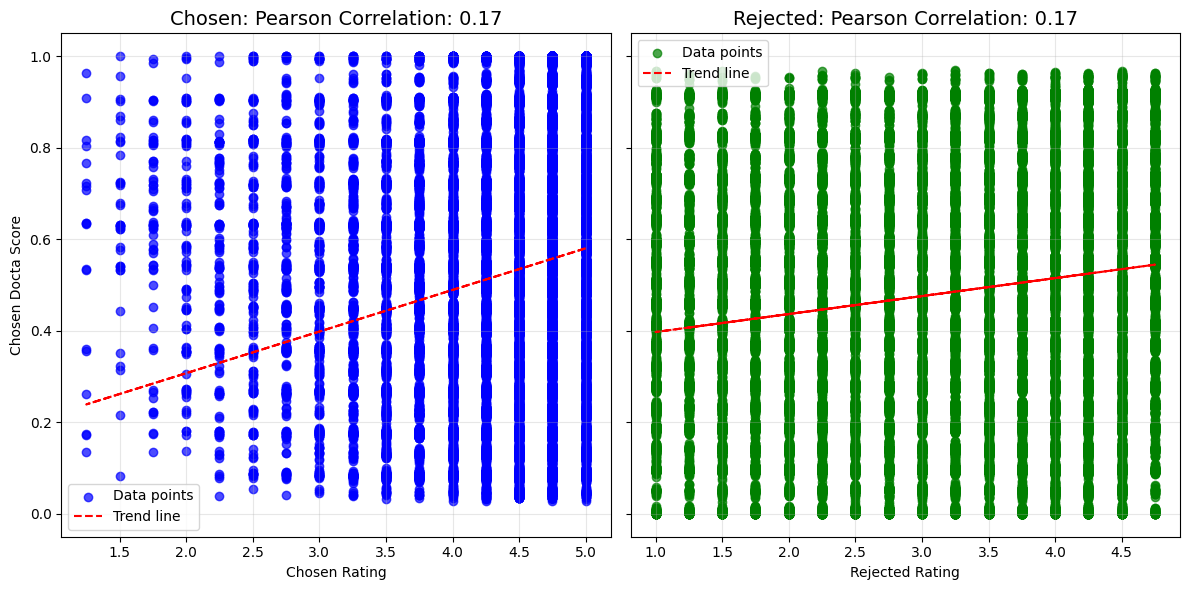

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 示例数据
chosen_rating = dataset_with_docta_score['chosen-rating']
rejected_rating = dataset_with_docta_score['rejected-rating']

chosen_docta_scores = dataset_with_docta_score['chosen_docta_score']
rejected_docta_scores = dataset_with_docta_score['rejected_docta_score']

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# 子图 1: Chosen
x1, y1 = chosen_rating, chosen_docta_scores
corr1, _ = pearsonr(x1, y1)

axes[0].scatter(x1, y1, color='blue', alpha=0.7, label='Data points')
z1 = np.polyfit(x1, y1, 1)
p1 = np.poly1d(z1)
axes[0].plot(x1, p1(x1), color='red', linestyle='--', label='Trend line')
axes[0].set_title(f"Chosen: Pearson Correlation: {corr1:.2f}", fontsize=14)
axes[0].set_xlabel("Chosen Rating")
axes[0].set_ylabel("Chosen Docta Score")
axes[0].legend()
axes[0].grid(alpha=0.3)

# 子图 2: Rejected
x2, y2 = rejected_rating, rejected_docta_scores
corr2, _ = pearsonr(x2, y2)

axes[1].scatter(x2, y2, color='green', alpha=0.7, label='Data points')
z2 = np.polyfit(x2, y2, 1)
p2 = np.poly1d(z2)
axes[1].plot(x2, p2(x2), color='red', linestyle='--', label='Trend line')
axes[1].set_title(f"Rejected: Pearson Correlation: {corr2:.2f}", fontsize=14)
axes[1].set_xlabel("Rejected Rating")
axes[1].legend()
axes[1].grid(alpha=0.3)

# 调整布局并显示图表
plt.tight_layout()
plt.show()


<BarContainer object of 16 artists>

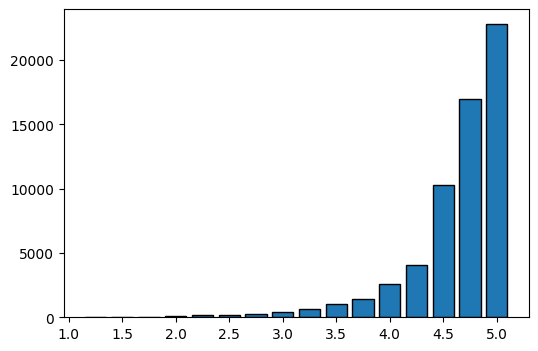

In [63]:
# import torch
from colllections import Counter

chosen_rating = dataset_with_docta_score['chosen-rating']
rejected_rating = dataset_with_docta_score['rejected-rating']

label_counts_revised = Counter(chosen_rating)
# print(f"Dataset {dataset_name}: Revised {label_counts_revised} \n")

# torch.save(chosen_docta_scores, path + "output_labels_revised.pt")


plt.figure(figsize=(6, 4))
keys_revised = list(label_counts_revised.keys())
values_revised = list(label_counts_revised.values())
plt.bar(keys_revised, values_revised, width=0.2, edgecolor='black')

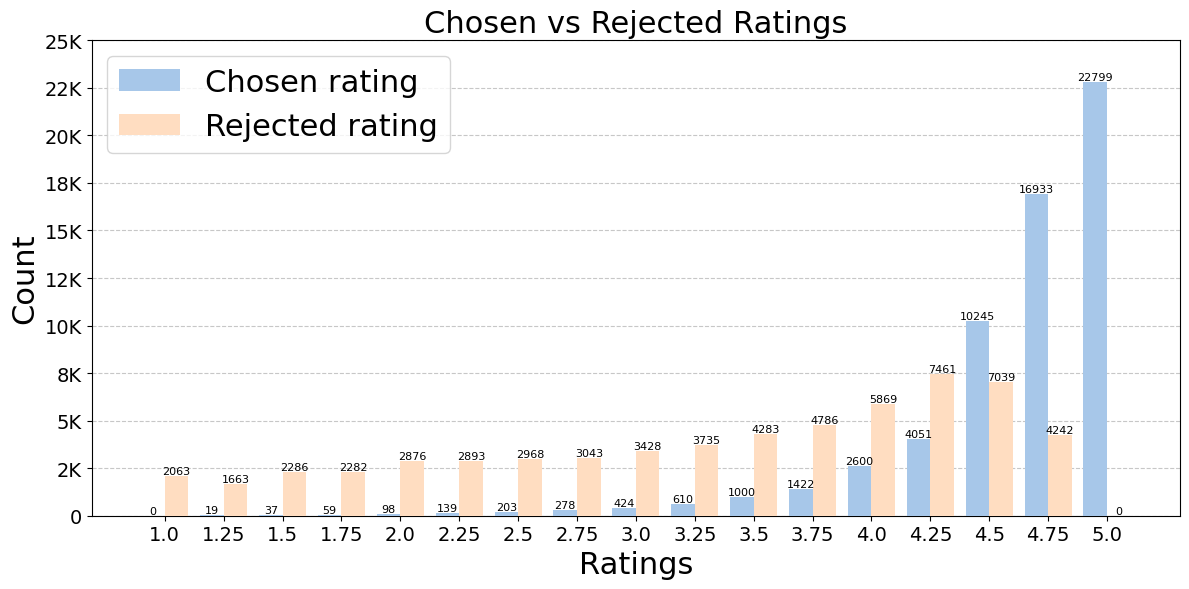

In [73]:
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.ticker import FuncFormatter

# 示例数据（用实际数据替换）
chosen_rating = dataset_with_docta_score['chosen-rating']
rejected_rating = dataset_with_docta_score['rejected-rating']

# 统计标签频次
label_counts_chosen = Counter(chosen_rating)
label_counts_rejected = Counter(rejected_rating)

# 提取标签和频次
labels = sorted(set(label_counts_chosen.keys()).union(set(label_counts_rejected.keys())))
counts_chosen = [label_counts_chosen[label] for label in labels]
counts_rejected = [label_counts_rejected[label] for label in labels]

# 绘制柱状图
bar_width = 0.1
fig, ax = plt.subplots(figsize=(12, 6))

# 绘制 Chosen 柱状图
bars_chosen = ax.bar(labels, counts_chosen, bar_width, label='Chosen rating', color='#A7C7E9', zorder=3)

# 绘制 Rejected 柱状图
bars_rejected = ax.bar([x + bar_width for x in labels], counts_rejected, bar_width, label='Rejected rating', color='#FFDDC1', zorder=3)

# 添加柱子顶部的数值
for bar in bars_chosen:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=8)

for bar in bars_rejected:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=8)

# 格式化 y 轴
def human_format(x, pos):
    if x >= 1e6:
        return f'{x * 1e-6:.1f}M'
    elif x >= 1e3:
        return f'{x * 1e-3:.0f}K'
    else:
        return f'{x:.0f}'

ax.yaxis.set_major_formatter(FuncFormatter(human_format))

# 设置标题和标签
ax.set_title('Chosen vs Rejected Ratings', fontsize=22)
ax.set_xlabel('Ratings', fontsize=22)
ax.set_ylabel('Count', fontsize=22)

# 设置 X 轴刻度为所有标签
ax.set_xticks([x + bar_width / 2 for x in labels])  # 居中对齐两个柱子
ax.set_xticklabels(labels, fontsize=12)

# 调整刻度
ax.tick_params(axis='x', rotation=0, labelsize=14)
ax.tick_params(axis='y', labelsize=14)
y_ticks = range(0, int(max(counts_chosen + counts_rejected) + 2500), 2500)
ax.set_yticks(y_ticks)

# 添加图例
ax.legend(loc='upper left', fontsize=22)

# 添加网格
ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

# 显示图表
plt.tight_layout()
plt.show()


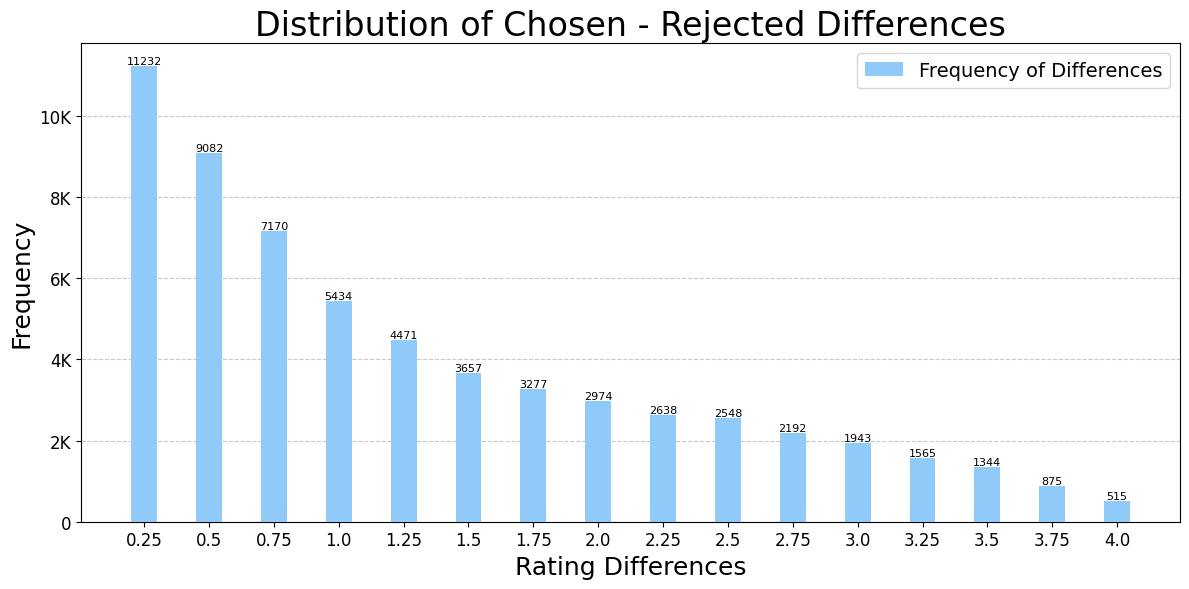

In [78]:
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.ticker import FuncFormatter

# 示例数据（用实际数据替换）
chosen_rating = dataset_with_docta_score['chosen-rating']
rejected_rating = dataset_with_docta_score['rejected-rating']

# 计算差值列表
rating_difference = [chosen - rejected for chosen, rejected in zip(chosen_rating, rejected_rating)]

# 统计差值频次
diff_counts = Counter(rating_difference)

# 提取差值标签和频次
labels = sorted(diff_counts.keys())
counts = [diff_counts[label] for label in labels]

# 绘制差值频次柱状图
fig, ax = plt.subplots(figsize=(12, 6))

# 绘制柱状图
bars_diff = ax.bar(labels, counts, bar_width, label='Frequency of Differences', color='#90CAF9', zorder=3)

# 添加柱子顶部的数值
for bar in bars_diff:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=8)

# 格式化 y 轴
def human_format(x, pos):
    if x >= 1e6:
        return f'{x * 1e-6:.1f}M'
    elif x >= 1e3:
        return f'{x * 1e-3:.0f}K'
    else:
        return f'{x:.0f}'

ax.yaxis.set_major_formatter(FuncFormatter(human_format))

# 设置标题和标签
ax.set_title('Distribution of Chosen - Rejected Differences', fontsize=24)
ax.set_xlabel('Rating Differences', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)

# 设置 X 轴刻度为所有差值
ax.set_xticks(labels)
ax.set_xticklabels(labels, fontsize=12)

# 调整刻度
ax.tick_params(axis='x', rotation=0, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# 添加图例
ax.legend(loc='upper right', fontsize=14)

# 添加网格
ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

# 显示图表
plt.tight_layout()
plt.show()


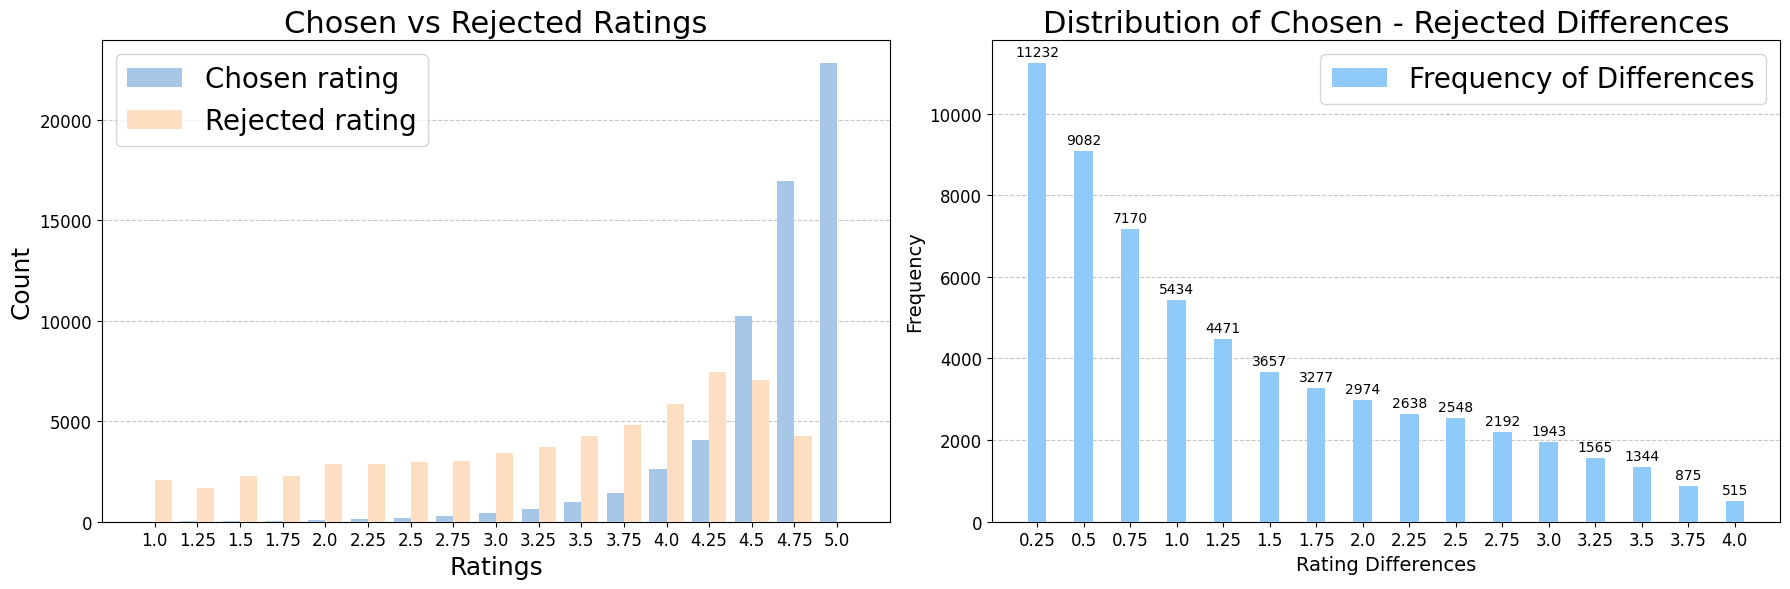

In [91]:
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.ticker import FuncFormatter

# 示例数据（用实际数据替换）
chosen_rating = dataset_with_docta_score['chosen-rating']
rejected_rating = dataset_with_docta_score['rejected-rating']

# ====== 图1数据处理 ======
# 统计标签频次
label_counts_chosen = Counter(chosen_rating)
label_counts_rejected = Counter(rejected_rating)

# 提取标签和频次
labels = sorted(set(label_counts_chosen.keys()).union(set(label_counts_rejected.keys())))
counts_chosen = [label_counts_chosen[label] for label in labels]
counts_rejected = [label_counts_rejected[label] for label in labels]

# ====== 图2数据处理 ======
# 计算差值列表
rating_difference = [chosen - rejected for chosen, rejected in zip(chosen_rating, rejected_rating)]

# 统计差值频次
diff_counts = Counter(rating_difference)

# 提取差值标签和频次
diff_labels = sorted(diff_counts.keys())
diff_counts_values = [diff_counts[label] for label in diff_labels]

# ====== 绘制子图 ======
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1]})

# ====== 子图1：Chosen vs Rejected ======
bar_width = 0.1
axs[0].bar(labels, counts_chosen, bar_width, label='Chosen rating', color='#A7C7E9', zorder=3)
axs[0].bar([x + bar_width for x in labels], counts_rejected, bar_width, label='Rejected rating', color='#FFDDC1', zorder=3)

# 添加柱子顶部数值
# for i, yval in enumerate(counts_chosen):
#     axs[0].text(labels[i], yval + 500, str(yval), ha='center', va='bottom', fontsize=10)
# for i, yval in enumerate(counts_rejected):
#     axs[0].text(labels[i] + bar_width, yval + 500, str(yval), ha='center', va='bottom', fontsize=10)

# 设置子图1标题和标签
axs[0].set_title('Chosen vs Rejected Ratings', fontsize=22)
axs[0].set_xlabel('Ratings', fontsize=18)
axs[0].set_ylabel('Count', fontsize=18)
axs[0].set_xticks([x + bar_width / 2 for x in labels])  # 居中对齐两个柱子
axs[0].set_xticklabels(labels, fontsize=12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].legend(loc='upper left', fontsize=20)
axs[0].grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

# ====== 子图2：Difference Distribution ======
bars_diff = axs[1].bar(diff_labels, diff_counts_values, bar_width, label='Frequency of Differences', color='#90CAF9', zorder=3)

# 添加柱子顶部数值
for i, yval in enumerate(diff_counts_values):
    axs[1].text(diff_labels[i], yval + 100, str(yval), ha='center', va='bottom', fontsize=10)

# 设置子图2标题和标签
axs[1].set_title('Distribution of Chosen - Rejected Differences', fontsize=22)
axs[1].set_xlabel('Rating Differences', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].set_xticks(diff_labels)
axs[1].set_xticklabels(diff_labels, fontsize=12)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].legend(loc='upper right', fontsize=20)
axs[1].grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

# ====== 调整整体布局 ======
plt.tight_layout()
plt.show()


## Plot Docta Score statists

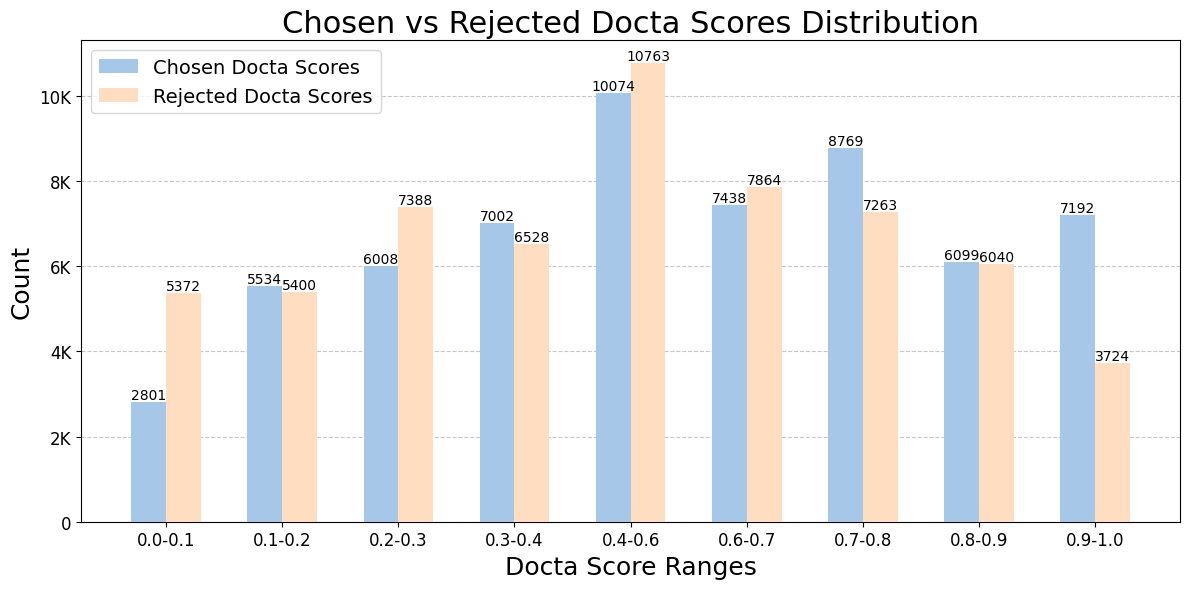

In [3]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from matplotlib.ticker import FuncFormatter

# 示例数据（用实际数据替换）
chosen_docta_scores = dataset_with_docta_score['chosen_docta_score']
rejected_docta_scores = dataset_with_docta_score['rejected_docta_score']

# 定义 bin 划分区间
bins = np.linspace(min(chosen_docta_scores + rejected_docta_scores), max(chosen_docta_scores + rejected_docta_scores), 10)

# 将 scores 根据 bins 划分到区间
chosen_binned = np.digitize(chosen_docta_scores, bins, right=True)
rejected_binned = np.digitize(rejected_docta_scores, bins, right=True)

# 统计每个 bin 的频次
chosen_counts = Counter(chosen_binned)
rejected_counts = Counter(rejected_binned)

# 转换为排序后的 bin 和频次
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
chosen_freqs = [chosen_counts[i] for i in range(1, len(bins))]
rejected_freqs = [rejected_counts[i] for i in range(1, len(bins))]

# 绘制柱状图
bar_width = 0.3
fig, ax = plt.subplots(figsize=(12, 6))

# 绘制 Chosen 柱状图
bars_chosen = ax.bar(range(len(labels)), chosen_freqs, bar_width, label='Chosen Docta Scores', color='#A7C7E9', zorder=3)

# 绘制 Rejected 柱状图
bars_rejected = ax.bar([x + bar_width for x in range(len(labels))], rejected_freqs, bar_width, label='Rejected Docta Scores', color='#FFDDC1', zorder=3)

# 添加柱子顶部的数值
for i, bar in enumerate(bars_chosen):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, str(yval), ha='center', va='bottom', fontsize=10)

for i, bar in enumerate(bars_rejected):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, str(yval), ha='center', va='bottom', fontsize=10)

# 格式化 y 轴
def human_format(x, pos):
    if x >= 1e6:
        return f'{x * 1e-6:.1f}M'
    elif x >= 1e3:
        return f'{x * 1e-3:.0f}K'
    else:
        return f'{x:.0f}'

ax.yaxis.set_major_formatter(FuncFormatter(human_format))

# 设置标题和标签
ax.set_title('Chosen vs Rejected Docta Scores Distribution', fontsize=22)
ax.set_xlabel('Docta Score Ranges', fontsize=18)
ax.set_ylabel('Count', fontsize=18)

# 设置 X 轴刻度
ax.set_xticks([x + bar_width / 2 for x in range(len(labels))])
ax.set_xticklabels(labels, fontsize=12)

# 调整刻度
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# 添加图例
ax.legend(loc='upper left', fontsize=14)

# 添加网格
ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

# 显示图表
plt.tight_layout()
plt.show()


In [2]:
from datasets import load_dataset

dataset = load_dataset("sahandrez/ultrafeedback_kto")['train']

In [14]:
from datasets import load_dataset

org_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")

org_dataset['train_prefs'].to_json("ultrafeedback_trainprefs.json")



Creating json from Arrow format: 100%|██████████| 62/62 [00:03<00:00, 15.85ba/s]


433383617

In [16]:
org_dataset['test_prefs'].to_json("ultrafeedback_testprefs.json")


Creating json from Arrow format: 100%|██████████| 2/2 [00:00<00:00, 13.21ba/s]


13984706

In [17]:
org_dataset['train_prefs']

Dataset({
    features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
    num_rows: 61135
})

In [ ]:



from datasets import load_dataset


train_dataset = load_dataset("jlpang888/ultrafeedback_sorted_score_diff")['train']

test_dataset = load_dataset("jlpang888/ultrafeedback_sorted_score_diff")['test']